### 트랜스포머와 GPT 모델의 차이점

#### - 인코더-디코더 기반에서 디코더만 남은 모델로 변경
#### - 포지셔널 임베딩, 마스크 어텐션, 피드포워드 3개 아키텍처로만 구성
#### - 디코더의 입력을 인코더의 출력이 아닌 학습데이터로 설정
#### - 디코더 층의 개수는 논문에 따라 12개로 설정
#### - 구체적인 변수 및 아키텍처, 학습 데이터 변화는 아래와 같음
##### 1. 아키텍처에서 인코더 레이어 함수와 모델 삭제
##### 2. 디코더 모델에서 크로스 어텐션 부분 삭제
##### 3. 오토 리그레시브를 위하여 학습 모델에서 입력문장의 정답레이블(encoder_output), 패딩마스크 전부 삭제
##### 4. 학습데이터는 질의와 응답을 하나의 문장으로 합치고 질의와 응답을 구분하기 위해 [SEP_TOKEN] 사용
##### 5. 디코더 인퍼런스 모델에서 [SEP_TOKEN] 이후 문장만 출력하도록 수정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Matplotlib is building the font cache; this may take a moment.


In [2]:
# 데이터 확인
data = pd.read_csv('data/ChatbotData .csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
# 원본 데이터 별도 확보
data_origin = data

In [4]:
# 각 컬럼별 최대 문장길이
data.astype(str).applymap(len).max()

Q        56
A        76
label     1
dtype: int64

In [5]:
import re

In [6]:
# 특수기호 찾아내는 함수 생성

def find_all_special_chars(df):
    pattern = re.compile(r"[^가-힣a-zA-Z0-9]")
    all_text = " ".join(df.astype(str).values.flatten())
    special_chars = set(pattern.findall(all_text))

    return special_chars

In [7]:
# 사용된 특수기호 목록
special_chars = find_all_special_chars(data)
special_chars

{' ',
 '!',
 '%',
 "'",
 ',',
 '-',
 '.',
 ';',
 '?',
 '_',
 '~',
 '…',
 'ㅊ',
 'ㅋ',
 'ㅎ',
 'ㅜ',
 'ㅠ'}

In [8]:
# 특수기호 포함된 문장 확인 함수

def contains_special_chars(value):
    for char in value:
        if char in (r'%',',', ';', '_', '-', '~', '…', 'ㅊ', 'ㅋ', 'ㅎ', 'ㅜ', 'ㅠ'):
            return True
    return False

def find_special_symbols(df):
    return df[df.astype(str).applymap(contains_special_chars).any(axis=1)]

In [9]:
# 특수기호가 포함된 문장 전체 확인을 위해 csv 파일로 저장
#find_special_symbols(data).to_csv("spc_contain_text.csv")

In [10]:
#7622, 9906번 문장 오타 확인
print(data.iloc[7622])
print(data.iloc[9906])

Q        이별후 8개월이란 시간이 흐르고
A         다른 인연이 ㅊ자아올 거예요.
label                    1
Name: 7622, dtype: object
Q                                               사랑의 정의
A        내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두넌 것이에요.-울라프
label                                                2
Name: 9906, dtype: object


In [11]:
# 오타 수정
data.iloc[7622, data.columns.get_loc("A")] = "다른 인연이 찾아올 거예요."
data.iloc[9906, data.columns.get_loc("A")] = "내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두는 것이에요.-울라프"

In [12]:
# 오타 수정 결과 확인
display(data.iloc[7622])
display(data.iloc[9906])

Q        이별후 8개월이란 시간이 흐르고
A          다른 인연이 찾아올 거예요.
label                    1
Name: 7622, dtype: object

Q                                               사랑의 정의
A        내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두는 것이에요.-울라프
label                                                2
Name: 9906, dtype: object

In [13]:
# 한국어 감정표현을 위해 특수문자는 살리기로 결정
# 반복되는 특수문자('ㅋㅋㅋ', 'ㅎㅎ' 등)는 1개 문자로만 표현
# 특수기호 처리 함수 생성

pattern = r'[!%\',.;?_~…ㅊㅋㅎㅜㅠ-]+'

def clean_text(text):
    return re.sub(pattern, lambda m: f' {m.group(0)[0]} ', text).strip()

In [14]:
# 특수기호 제거 함수 적용
data = data.astype(str).applymap(clean_text)

data

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,PPL 심하네,눈살이 찌푸려지죠 .,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임 .,티가 나니까 눈치가 보이는 거죠 !,2
11819,훔쳐보는 것도 눈치 보임 .,훔쳐보는 거 티나나봐요 .,2
11820,흑기사 해주는 짝남 .,설렜겠어요 .,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요 .,2


In [15]:
#data.to_csv('preprocessed_text.csv', index = False)

In [16]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [45]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [18]:
# 멀티헤드어텐션 함수

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [43]:
# 디코더 모델은 오토 리그레시브로 패딩마스크 미사용
# 하는줄 알았으나 아래 룩어헤드 마스크에서 쓰임...

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [20]:
# 뒤쪽 단어 마스킹을 위한 룩어헤드마스크 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [21]:
# 인코더 레이어 삭제

'''
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
      '''

'\ndef encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):\n  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)\n  attention = MultiHeadAttention(\n      d_model, num_heads, name="attention")({\n          \'query\': inputs,\n          \'key\': inputs,\n          \'value\': inputs,\n          \'mask\': padding_mask\n      })\n\n  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행\n  attention = tf.keras.layers.Dropout(rate=dropout)(attention)\n  attention = tf.keras.layers.LayerNormalization(\n      epsilon=1e-6)(inputs + attention)\n\n  # 두 번째 서브 레이어 : 2개의 완전연결층\n  outputs = tf.keras.layers.Dense(units=units, activation=\'relu\')(attention)\n  outputs = tf.keras.layers.Dense(units=d_model)(outputs)\n\n  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행\n  outputs = tf.keras.layers.Dropout(rate=dropout)(out

In [22]:
# 인코더 아키텍처 삭제

'''
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
      '''

'\ndef encoder(vocab_size,\n            num_layers,\n            units,\n            d_model,\n            num_heads,\n            dropout,\n            name="encoder"):\n  inputs = tf.keras.Input(shape=(None,), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 임베딩 레이어\n  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)\n  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))\n\n  # 포지셔널 인코딩\n  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)\n\n  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)\n\n  # num_layers만큼 쌓아올린 인코더의 층.\n  for i in range(num_layers):\n    outputs = encoder_layer(\n        units=units,\n        d_model=d_model,\n        num_heads=num_heads,\n        dropout=dropout,\n        name="encoder_layer_{}".format(i),\n    )([outputs, padding_mask])\n\n  return tf.keras.Model(\n      inputs=[inputs, padding_mask], outputs=outputs, name=name)\n      '

In [23]:
# gpt디코더로 레이어 이름 변경

# 디코더 하나의 레이어를 함수로 구현.
def gpt_decoder_layer(units, d_model, num_heads, dropout, name="gpt_decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  # 인코더 출력 변수 제거
  # enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  
  # 오토 리그레시브를 위해 패딩 마스크 제거
  # padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 하나의 마스크 멀티헤드어텐션만 활용하므로 크로스어텐션 제거

  '''
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)
      '''
  # 크로스어텐션이 없으니 피드포워드층의 입력은 attention1(첫번째 어텐션층 출력) 되어야 함

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 잔차연결에서도 attention1(첫번째 어텐션층 출력)을 더해야 함
  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  # 리턴문에서도 입력에 들어있는 인코더 아웃풋, 패딩마스크 제거
  return tf.keras.Model(
      inputs=[inputs, 
              #enc_outputs,
              look_ahead_mask],
              #padding_mask],
      outputs=outputs,
      name=name)

In [24]:
# gpt_decoder로 이름 변경
# 임베딩 + 포지셔널인코딩 + 여러겹의 인코딩 레이어

def gpt_decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='gpt_decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  # 인코더 출력 변수 제거
  #enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 오토 리그레시브를 위해 패딩 마스크 제거
  # padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더 인풋에서 인코더 인풋과 패딩 마스크 삭제
  for i in range(num_layers):
    outputs = gpt_decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='gpt_decoder_layer_{}'.format(i),
    )(inputs=[outputs,
             # enc_outputs,
              look_ahead_mask
             # padding_mask
             ])

  # 리턴문에서도 입력에 들어있는 인코더 아웃풋, 패딩마스크 제거
  return tf.keras.Model(
      inputs=[inputs,
              #enc_outputs,
              look_ahead_mask],
              #padding_mask],
      outputs=outputs,
      name=name)

In [28]:
import tensorflow_datasets as tfds

In [65]:
# 인코더-디코더 기반의 모델에서는 질문과 대답을 별개 문장으로 학습
# 디코더 모델에서는 하나의 문장으로 만들어야 함
# 질문과 답변 사이에는 '[SEP_TOKEN]'을 넣어 구별(사전 크기도 1개 더 늘어나야 함)

# 질문과 답변을 하나의 문장으로 재생성

data["full_texts"] = data["Q"] + " " + data["A"]

In [66]:
data

,Q,A,label,full_texts
0,12시 땡 !,하루가 또 가네요 .,0,12시 땡 ! 하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .,0,1지망 학교 떨어졌어 위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0,3박4일 놀러가고 싶다 여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0,3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠 .,0,PPL 심하네 눈살이 찌푸려지죠 .
...,...,...,...,...
11818,훔쳐보는 것도 눈치 보임 .,티가 나니까 눈치가 보이는 거죠 !,2,훔쳐보는 것도 눈치 보임 . 티가 나니까 눈치가 보이는 거죠 !
11819,훔쳐보는 것도 눈치 보임 .,훔쳐보는 거 티나나봐요 .,2,훔쳐보는 것도 눈치 보임 . 훔쳐보는 거 티나나봐요 .
11820,흑기사 해주는 짝남 .,설렜겠어요 .,2,흑기사 해주는 짝남 . 설렜겠어요 .
11821,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요 .,2,힘든 연애 좋은 연애라는게 무슨 차이일까 ? 잘 헤어질 수 있는 사이 여부인 거 같...


In [67]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [68]:
# 단어집합 개수 획인
tokenizer.vocab_size

8361

In [69]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
# 디코더 모델에서는 SEP_TOKEN까지 추가
START_TOKEN, END_TOKEN, SEP_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size + 2]

In [70]:
# 단어장에 시작토큰와 종료토큰, 구분토큰 개수 추가
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8364


In [71]:
# 질문 텍스트에서 토크나이징 후 토큰 개수가 가장 많은 문장을 확인
tokenized_text = [(sentence, len(tokenizer.encode(sentence))) for sentence in data["full_texts"]]

longest_sentence, max_tokens = max(tokenized_text, key=lambda x: x[1])

print(f"질문 문장에서 토큰 개수가 가장 많은 문장: {longest_sentence}")
print(f"토큰 개수: {max_tokens}")

질문 문장에서 토큰 개수가 가장 많은 문장: 썸 탈 때 연락문제로 속상한 적 있어 ? 썸 탈 때는 특히 속상한 것 같아요 .  내 맘 같지 않고 아직 내 사람이 아니니까요 .  그래도 그 순간을 즐겨보는 건 어떨까요 ?
토큰 개수: 39


In [81]:
# 토큰 개수가 가장 많은 문장의 토큰 개수인 max_tokens을 최대 길이로 사용
# 패딩 수행

MAX_LENGTH = max_tokens + 3

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩 적용
def tokenize_and_filter(inputs, outputs):
    tokenized_sequences = []

    for (question, answer) in zip(inputs, outputs):
        # 질문과 답변을 SEP_TOKEN으로 연결한 후 토큰화
        combined_sentence = START_TOKEN + tokenizer.encode(question) + SEP_TOKEN + tokenizer.encode(answer) + END_TOKEN

        # 최대 길이 초과하는 샘플 제거
        if len(combined_sentence) <= MAX_LENGTH:
            tokenized_sequences.append(combined_sentence)

    # 패딩 적용
    tokenized_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_sequences, maxlen=MAX_LENGTH, padding='post')

    return tokenized_sequences

In [82]:
full_sentences = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8364
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [84]:
# 질의와 응답이 하나로 합쳐진 데이터를 활용한 오토 리그레시브 데이터셋

BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': full_sentences[:, :-1],
        #'dec_inputs': answers[:, :-1]
    },
    {
        'softmax_outputs': full_sentences[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [85]:
# 디코더 모델 생성

def gpt_model(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                temperature = 1.0,
                name="gpt_model"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더 인풋(인코딩의 정답문장) 제거
  #dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 패딩마스크 제거
  '''
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
    '''


  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      # 디코더 인풋을 인코딩의 정답문장(dec_inputs) 에서 inputs으로 변경
      name='look_ahead_mask')(inputs)

  # 패딩마크스와 인코더 아키텍처 제거
  '''
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])
  '''

  # 디코더 출력 변수에서 인코더 아웃풋, 패딩마스크 제거
  # encoder_inputs 변수를 inputs으로 변경
  dec_outputs = gpt_decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs,
            #enc_outputs,
            look_ahead_mask
            #dec_padding_mask
           ])

  # 완전연결층(소프트맥스 출력 전 로짓의 온도 조정)
  logits = tf.keras.layers.Dense(units=vocab_size, name="logits")(dec_outputs)
  scaled_logits = tf.keras.layers.Lambda(lambda x: x / temperature, name="temperature_scaling")(logits)
  outputs = tf.keras.layers.Softmax(name="softmax_outputs")(scaled_logits)

  # 리턴에서도 모델의 입력에서 dec_inputs 삭제
  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [86]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
TEMPARATURE = 1.0 # 소프트맥스 온도 설정

model1_1 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model1_2 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model1_3 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model1_1.summary()

Model: "gpt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
gpt_decoder (Functional)        (None, None, 256)    3195392     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
logits (Dense)                  (None, None, 8364)   2149548     gpt_decoder[0][0]        

In [87]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
TEMPARATURE = 0.5 # 소프트맥스 온도 설정

model2_1 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model2_2 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model2_3 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model2_1.summary()

Model: "gpt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
gpt_decoder (Functional)        (None, None, 256)    3195392     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
logits (Dense)                  (None, None, 8364)   2149548     gpt_decoder[0][0]        

In [88]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
TEMPARATURE = 2.0 # 소프트맥스 온도 설정

model3_1 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model3_2 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model3_3 = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    temperature=TEMPARATURE)

model3_1.summary()

Model: "gpt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
gpt_decoder (Functional)        (None, None, 256)    3195392     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
logits (Dense)                  (None, None, 8364)   2149548     gpt_decoder[0][0]        

In [89]:
# 패딩영역을 신경쓰지 않은 손실함수 계산

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=False, reduction='none')(y_true, y_pred)

  #mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  #loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [90]:
# 학습률 커스터마이징
# 4000번의 웜업 이후 학습률을 줄이는 형태로 설정

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [91]:
#모델 컴파일

# 학습률 스케줄 설정
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수 정의
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [92]:
# 모델 컴파일
model1_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model1_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model1_3.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model2_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model2_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model2_3.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model3_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model3_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model3_3.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Epoch 1/20
185/185 [==============================] - 29s 40ms/step - loss: 7.1619 - accuracy: 0.5004
Epoch 2/20
185/185 [==============================] - 7s 40ms/step - loss: 3.7141 - accuracy: 0.6787
Epoch 3/20
185/185 [==============================] - 7s 40ms/step - loss: 2.2135 - accuracy: 0.7429
Epoch 4/20
185/185 [==============================] - 7s 40ms/step - loss: 1.9599 - accuracy: 0.7508
Epoch 5/20
185/185 [==============================] - 7s 40ms/step - loss: 1.8450 - accuracy: 0.7572
Epoch 6/20
185/185 [==============================] - 7s 40ms/step - loss: 1.7511 - accuracy: 0.7629
Epoch 7/20
185/185 [==============================] - 7s 40ms/step - loss: 1.6571 - accuracy: 0.7685
Epoch 8/20
185/185 [==============================] - 7s 40ms/step - loss: 1.5606 - accuracy: 0.7756
Epoch 9/20
185/185 [==============================] - 7s 40ms/step - loss: 1.4593 - accuracy: 0.7839
Epoch 10/20
185/185 [==============================] - 7s 41ms/step - loss: 1.3543 - accur

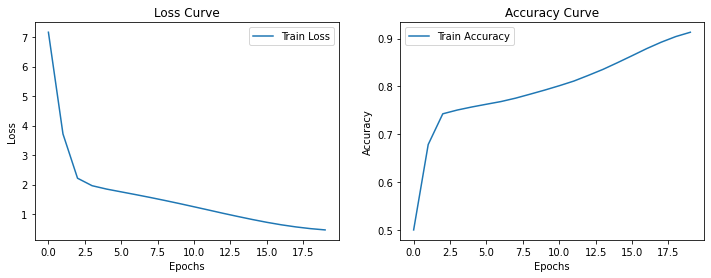

In [93]:
# 학습 수행
EPOCHS = 20
history1_1 = model1_1.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history1_1):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history1_1.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history1_1.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history1_1)

Epoch 1/40
185/185 [==============================] - 7s 40ms/step - loss: 0.3287 - accuracy: 0.9413
Epoch 2/40
185/185 [==============================] - 7s 40ms/step - loss: 0.3098 - accuracy: 0.9451
Epoch 3/40
185/185 [==============================] - 7s 40ms/step - loss: 0.3053 - accuracy: 0.9459
Epoch 4/40
185/185 [==============================] - 7s 40ms/step - loss: 0.3021 - accuracy: 0.9466
Epoch 5/40
185/185 [==============================] - 7s 40ms/step - loss: 0.2992 - accuracy: 0.9469
Epoch 6/40
185/185 [==============================] - 7s 40ms/step - loss: 0.2968 - accuracy: 0.9476
Epoch 7/40
185/185 [==============================] - 7s 40ms/step - loss: 0.2949 - accuracy: 0.9479
Epoch 8/40
185/185 [==============================] - 7s 40ms/step - loss: 0.2936 - accuracy: 0.9480
Epoch 9/40
185/185 [==============================] - 7s 40ms/step - loss: 0.2918 - accuracy: 0.9484
Epoch 10/40
185/185 [==============================] - 7s 40ms/step - loss: 0.2904 - accura

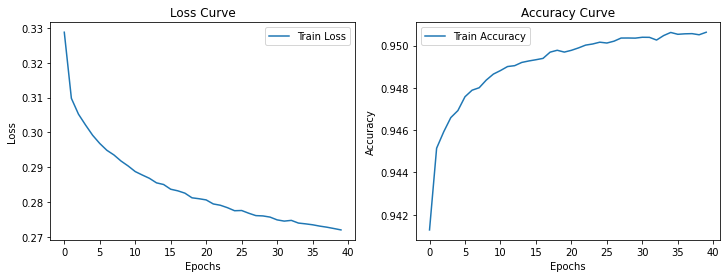

In [143]:
# 학습 수행
EPOCHS = 40
history1_2 = model1_2.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history1_2):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history1_2.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history1_2.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history1_2)

Epoch 1/60
185/185 [==============================] - 10s 40ms/step - loss: 2.4706 - accuracy: 0.7220
Epoch 2/60
185/185 [==============================] - 7s 40ms/step - loss: 1.8280 - accuracy: 0.7585
Epoch 3/60
185/185 [==============================] - 7s 40ms/step - loss: 1.6231 - accuracy: 0.7716
Epoch 4/60
185/185 [==============================] - 7s 40ms/step - loss: 1.4265 - accuracy: 0.7863
Epoch 5/60
185/185 [==============================] - 7s 40ms/step - loss: 1.2437 - accuracy: 0.8011
Epoch 6/60
185/185 [==============================] - 7s 40ms/step - loss: 1.0799 - accuracy: 0.8167
Epoch 7/60
185/185 [==============================] - 7s 40ms/step - loss: 0.9353 - accuracy: 0.8331
Epoch 8/60
185/185 [==============================] - 7s 40ms/step - loss: 0.8080 - accuracy: 0.8505
Epoch 9/60
185/185 [==============================] - 7s 40ms/step - loss: 0.6993 - accuracy: 0.8672
Epoch 10/60
185/185 [==============================] - 7s 40ms/step - loss: 0.6084 - accur

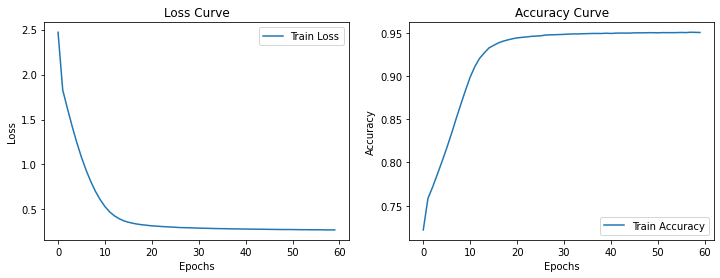

In [100]:
# 학습 수행
EPOCHS = 60
history1_3 = model1_3.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history1_3):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history1_3.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history1_3.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history1_3)

Epoch 1/20
185/185 [==============================] - 10s 41ms/step - loss: 2.2899 - accuracy: 0.7314
Epoch 2/20
185/185 [==============================] - 7s 41ms/step - loss: 1.7710 - accuracy: 0.7623
Epoch 3/20
185/185 [==============================] - 7s 40ms/step - loss: 1.5641 - accuracy: 0.7756
Epoch 4/20
185/185 [==============================] - 7s 40ms/step - loss: 1.3906 - accuracy: 0.7886
Epoch 5/20
185/185 [==============================] - 7s 40ms/step - loss: 1.2404 - accuracy: 0.8007
Epoch 6/20
185/185 [==============================] - 7s 40ms/step - loss: 1.1060 - accuracy: 0.8125
Epoch 7/20
185/185 [==============================] - 7s 40ms/step - loss: 0.9865 - accuracy: 0.8254
Epoch 8/20
185/185 [==============================] - 7s 40ms/step - loss: 0.8788 - accuracy: 0.8388
Epoch 9/20
185/185 [==============================] - 7s 40ms/step - loss: 0.7818 - accuracy: 0.8535
Epoch 10/20
185/185 [==============================] - 7s 40ms/step - loss: 0.6948 - accur

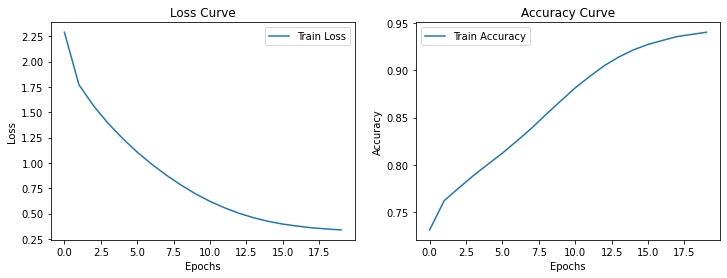

In [144]:
# 학습 수행
EPOCHS = 20
history2_1 = model2_1.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history2_1):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history2_1.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history2_1.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history2_1)

Epoch 1/40
185/185 [==============================] - 10s 41ms/step - loss: 2.3118 - accuracy: 0.7307
Epoch 2/40
185/185 [==============================] - 7s 40ms/step - loss: 1.7747 - accuracy: 0.7618
Epoch 3/40
185/185 [==============================] - 7s 40ms/step - loss: 1.5747 - accuracy: 0.7744
Epoch 4/40
185/185 [==============================] - 7s 40ms/step - loss: 1.4076 - accuracy: 0.7870
Epoch 5/40
185/185 [==============================] - 7s 40ms/step - loss: 1.2630 - accuracy: 0.7983
Epoch 6/40
185/185 [==============================] - 7s 40ms/step - loss: 1.1328 - accuracy: 0.8102
Epoch 7/40
185/185 [==============================] - 7s 40ms/step - loss: 1.0164 - accuracy: 0.8222
Epoch 8/40
185/185 [==============================] - 7s 40ms/step - loss: 0.9107 - accuracy: 0.8350
Epoch 9/40
185/185 [==============================] - 8s 41ms/step - loss: 0.8149 - accuracy: 0.8486
Epoch 10/40
185/185 [==============================] - 8s 41ms/step - loss: 0.7296 - accur

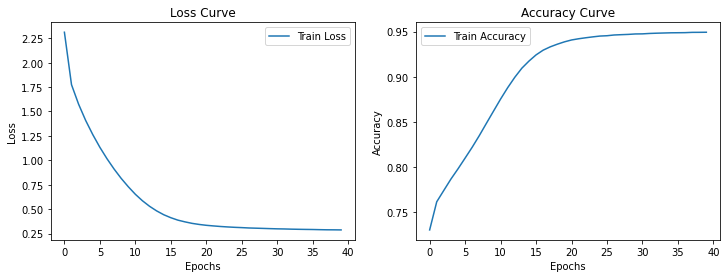

In [145]:
# 학습 수행
EPOCHS = 40
history2_2 = model2_2.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history2_2):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history2_2.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history2_2.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history2_2)

Epoch 1/60
185/185 [==============================] - 10s 41ms/step - loss: 2.3350 - accuracy: 0.7283
Epoch 2/60
185/185 [==============================] - 7s 40ms/step - loss: 1.8103 - accuracy: 0.7599
Epoch 3/60
185/185 [==============================] - 7s 40ms/step - loss: 1.6233 - accuracy: 0.7711
Epoch 4/60
185/185 [==============================] - 7s 40ms/step - loss: 1.4653 - accuracy: 0.7826
Epoch 5/60
185/185 [==============================] - 7s 40ms/step - loss: 1.3263 - accuracy: 0.7933
Epoch 6/60
185/185 [==============================] - 7s 40ms/step - loss: 1.2012 - accuracy: 0.8037
Epoch 7/60
185/185 [==============================] - 7s 40ms/step - loss: 1.0895 - accuracy: 0.8142
Epoch 8/60
185/185 [==============================] - 7s 40ms/step - loss: 0.9856 - accuracy: 0.8259
Epoch 9/60
185/185 [==============================] - 8s 41ms/step - loss: 0.8914 - accuracy: 0.8381
Epoch 10/60
185/185 [==============================] - 7s 40ms/step - loss: 0.8063 - accur

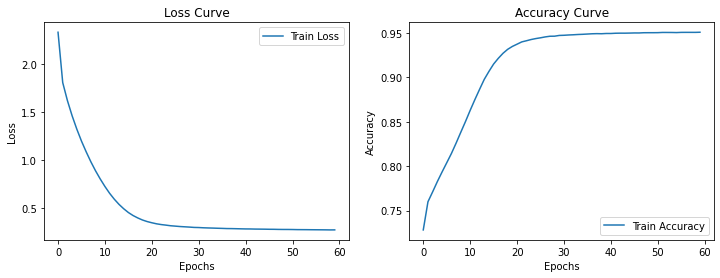

In [146]:
# 학습 수행
EPOCHS = 60
history2_3 = model2_3.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history2_3):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history2_3.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history2_3.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history2_3)

Epoch 1/20
185/185 [==============================] - 10s 41ms/step - loss: 3.8497 - accuracy: 0.6787
Epoch 2/20
185/185 [==============================] - 8s 41ms/step - loss: 2.0278 - accuracy: 0.7488
Epoch 3/20
185/185 [==============================] - 7s 40ms/step - loss: 1.8734 - accuracy: 0.7554
Epoch 4/20
185/185 [==============================] - 7s 40ms/step - loss: 1.7906 - accuracy: 0.7606
Epoch 5/20
185/185 [==============================] - 7s 40ms/step - loss: 1.7214 - accuracy: 0.7648
Epoch 6/20
185/185 [==============================] - 7s 40ms/step - loss: 1.6606 - accuracy: 0.7684
Epoch 7/20
185/185 [==============================] - 7s 40ms/step - loss: 1.6030 - accuracy: 0.7729
Epoch 8/20
185/185 [==============================] - 7s 40ms/step - loss: 1.5470 - accuracy: 0.7775
Epoch 9/20
185/185 [==============================] - 7s 40ms/step - loss: 1.4914 - accuracy: 0.7822
Epoch 10/20
185/185 [==============================] - 8s 41ms/step - loss: 1.4369 - accur

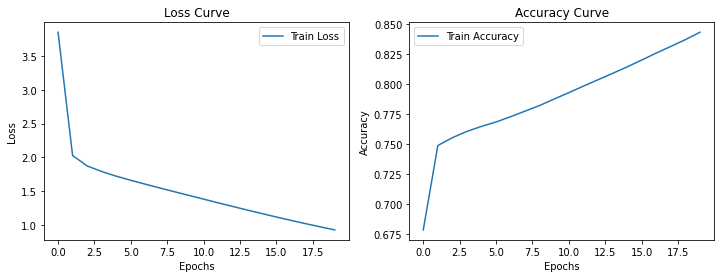

In [147]:
# 학습 수행
EPOCHS = 20
history3_1 = model3_1.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history3_1):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history3_1.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history3_1.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history3_1)

Epoch 1/40
185/185 [==============================] - 10s 41ms/step - loss: 3.8872 - accuracy: 0.6775
Epoch 2/40
185/185 [==============================] - 7s 40ms/step - loss: 2.0419 - accuracy: 0.7483
Epoch 3/40
185/185 [==============================] - 7s 40ms/step - loss: 1.8854 - accuracy: 0.7549
Epoch 4/40
185/185 [==============================] - 8s 41ms/step - loss: 1.8022 - accuracy: 0.7599
Epoch 5/40
185/185 [==============================] - 7s 41ms/step - loss: 1.7340 - accuracy: 0.7641
Epoch 6/40
185/185 [==============================] - 7s 40ms/step - loss: 1.6726 - accuracy: 0.7680
Epoch 7/40
185/185 [==============================] - 7s 40ms/step - loss: 1.6164 - accuracy: 0.7719
Epoch 8/40
185/185 [==============================] - 8s 41ms/step - loss: 1.5621 - accuracy: 0.7763
Epoch 9/40
185/185 [==============================] - 7s 40ms/step - loss: 1.5081 - accuracy: 0.7813
Epoch 10/40
185/185 [==============================] - 7s 40ms/step - loss: 1.4555 - accur

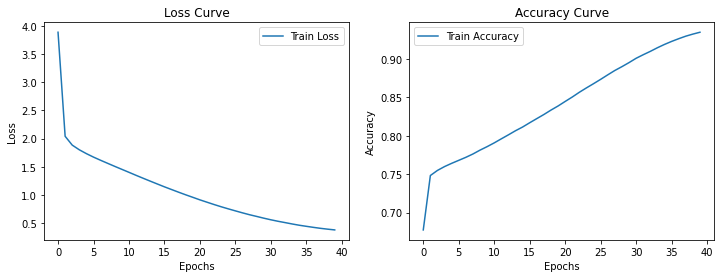

In [148]:
# 학습 수행
EPOCHS = 40
history3_2 = model3_2.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history3_2):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history3_2.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history3_2.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history3_2)

Epoch 1/60
185/185 [==============================] - 10s 41ms/step - loss: 4.0147 - accuracy: 0.6745
Epoch 2/60
185/185 [==============================] - 7s 40ms/step - loss: 2.0660 - accuracy: 0.7470
Epoch 3/60
185/185 [==============================] - 7s 40ms/step - loss: 1.8977 - accuracy: 0.7545
Epoch 4/60
185/185 [==============================] - 7s 40ms/step - loss: 1.8133 - accuracy: 0.7597
Epoch 5/60
185/185 [==============================] - 7s 40ms/step - loss: 1.7483 - accuracy: 0.7633
Epoch 6/60
185/185 [==============================] - 7s 40ms/step - loss: 1.6909 - accuracy: 0.7669
Epoch 7/60
185/185 [==============================] - 7s 40ms/step - loss: 1.6377 - accuracy: 0.7700
Epoch 8/60
185/185 [==============================] - 7s 40ms/step - loss: 1.5889 - accuracy: 0.7735
Epoch 9/60
185/185 [==============================] - 8s 41ms/step - loss: 1.5407 - accuracy: 0.7774
Epoch 10/60
185/185 [==============================] - 7s 40ms/step - loss: 1.4927 - accur

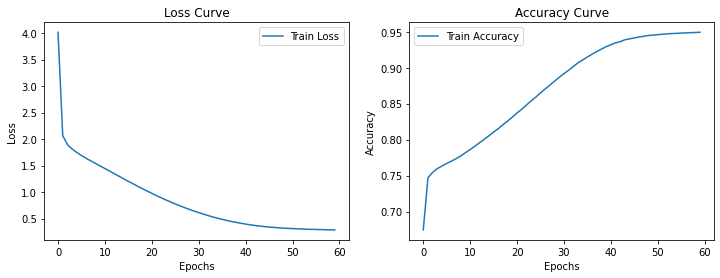

In [149]:
# 학습 수행
EPOCHS = 60
history3_3 = model3_3.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history3_3):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history3_3.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history3_3.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history3_3)

In [154]:
def decoder_inference(sentence, model):
    sentence = clean_text(sentence)

    # 입력 문장을 토크나이징 후 START_TOKEN 추가
    input_ids = tokenizer.encode(sentence)
    output_sequence = tf.expand_dims(START_TOKEN + input_ids + SEP_TOKEN, axis=0)

    for _ in range(MAX_LENGTH):
        predictions = model(inputs=output_sequence, training=False)
        predictions = predictions[:, -1:, :]  # 마지막 토큰만 가져오기

        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
        # SEP_TOKEN 이후의 토큰만 추출
        output_tokens = output_sequence.numpy().tolist()[0]
        
        if SEP_TOKEN[0] in output_tokens:
            # SEP_TOKEN 인덱스 추출
            sep_idx = output_tokens.index(SEP_TOKEN[0])
            # SEP_TOKEN 인덱스 이후 토큰들만 output_tokens에 담기
            output_tokens = output_tokens[sep_idx + 1:]

    return output_tokens

In [155]:
def sentence_generation_multi_models(sentence, models):
    for model in models:
        prediction = decoder_inference(sentence, model)

        predicted_sentence = tokenizer.decode(
            [i for i in prediction if i < tokenizer.vocab_size]
        )

        # 특정 특수문자 앞 공백 제거
        predicted_sentence = re.sub(r'\s*([!%\',.;?_~…ㅊㅋㅎㅜㅠ-])', r'\1', predicted_sentence)
        
        # 테스트 조건별 출력
        if model == model1_1: 
            print('온도1.0, 학습횟수20 출력 : {}'.format(predicted_sentence))
        if model == model1_2: 
            print('온도1.0, 학습횟수40 출력 : {}'.format(predicted_sentence))
        if model == model1_3: 
            print('온도1.0, 학습횟수60 출력 : {}'.format(predicted_sentence))
            print("\n")
        if model == model2_1: 
            print('온도0.5, 학습횟수20 출력 : {}'.format(predicted_sentence))
        if model == model2_2: 
            print('온도0.5, 학습횟수40 출력 : {}'.format(predicted_sentence))
        if model == model2_3: 
            print('온도0.5, 학습횟수60 출력 : {}'.format(predicted_sentence))
            print("\n")
        if model == model3_1: 
            print('온도2.0, 학습횟수20 출력 : {}'.format(predicted_sentence))
        if model == model3_2: 
            print('온도2.0, 학습횟수40 출력 : {}'.format(predicted_sentence))
        if model == model3_3: 
            print('온도2.0, 학습횟수60 출력 : {}'.format(predicted_sentence))

In [156]:
# model1_1 -> 소프트맥스 온도 1.0, 학습횟수 20
# model1_2 -> 소프트맥스 온도 1.0, 학습횟수 40
# model1_3 -> 소프트맥스 온도 1.0, 학습횟수 60
# model2_1 -> 소프트맥스 온도 0.5, 학습횟수 20
# model2_2 -> 소프트맥스 온도 0.5, 학습횟수 40
# model2_3 -> 소프트맥스 온도 0.5, 학습횟수 60
# model3_1 -> 소프트맥스 온도 2.0, 학습횟수 20
# model3_2 -> 소프트맥스 온도 2.0, 학습횟수 40
# model3_3 -> 소프트맥스 온도 2.0, 학습횟수 60
#models = [model1_3]
models = [model1_1,model1_2,model1_3, model2_1,model2_2,model2_3, model3_1,model3_2,model3_3]

In [157]:
# 테스트1
sentence_generation_multi_models('나랑 같이 밥 먹을래?', models)

온도1.0, 학습횟수20 출력 : 저는 좋아요.
온도1.0, 학습횟수40 출력 : 그 사람의 말을 자주해겠죠.
온도1.0, 학습횟수60 출력 : 이제 못 놓쳐요.


온도0.5, 학습횟수20 출력 : 당신이요.
온도0.5, 학습횟수40 출력 : 새로운 관계를 만들면 돼요.
온도0.5, 학습횟수60 출력 : 새로운 관계를 만들면 돼요.


온도2.0, 학습횟수20 출력 : 같이 놀아요.
온도2.0, 학습횟수40 출력 : 저기압에는 고기앞이죠.
온도2.0, 학습횟수60 출력 : 혼자 사는 것도 나쁘지 않아요.


In [158]:
# 테스트2
sentence_generation_multi_models('우리 약속은 내일로 미룰까?', models)

온도1.0, 학습횟수20 출력 : 엄청 놀랐겠네요.
온도1.0, 학습횟수40 출력 : 사람마다 정의가 다를 것 같아요.
온도1.0, 학습횟수60 출력 : 정 끝에 해주는 게 좋죠.


온도0.5, 학습횟수20 출력 : 만나면 인사를 유하고 결정을 내리네요.
온도0.5, 학습횟수40 출력 : 방약이 있을 거예요.
온도0.5, 학습횟수60 출력 : 장은 듯할 수 있는 곳이 나봐요.


온도2.0, 학습횟수20 출력 : 그런 생각은 자신을 더 사랑해주세요.
온도2.0, 학습횟수40 출력 : 충분히 어울릴 수 있어요.
온도2.0, 학습횟수60 출력 : 꼭 움직후로 돌아갈 거예요.


In [159]:
# 테스트2
sentence_generation_multi_models('내가 약속이 있어서 그런데 우리 약속은 내일로 미룰까?', models)

온도1.0, 학습횟수20 출력 : 다른 걸 잊지 마세요.
온도1.0, 학습횟수40 출력 : 사랑이 숨 쉬고 있어요.
온도1.0, 학습횟수60 출력 : 좋아난한 이유가 보는 건 어떨까요.


온도0.5, 학습횟수20 출력 : 짐작하는 건 없어요.
온도0.5, 학습횟수40 출력 : 방식에 대한 사랑이 둘하게 말해보세요.
온도0.5, 학습횟수60 출력 : 니다.


온도2.0, 학습횟수20 출력 : 그런 사람 만나세요.
온도2.0, 학습횟수40 출력 : 고백을 안하고 사귀는 경우도 있지만 정확하게 물어보는게 좋아요.  더 좋은 방법이겠죠.
온도2.0, 학습횟수60 출력 : 정말 중요한데요.


In [160]:
# 테스트3
sentence_generation_multi_models('내 여자친구는 나를 안좋아하는거 같아 ㅠㅜ', models)

온도1.0, 학습횟수20 출력 : 마음이 떠난 사람을 잊는다는 건 쉬운 일이 아니니까요.
온도1.0, 학습횟수40 출력 : 이제 그런 것 같아요.
온도1.0, 학습횟수60 출력 : 이제 신경 쓰일만 해요.


온도0.5, 학습횟수20 출력 : 인연이 거기까지인가봐요.
온도0.5, 학습횟수40 출력 : 사랑은 더 잘하게 될 거예요.
온도0.5, 학습횟수60 출력 : 자신의 마음에 달려 합니다.


온도2.0, 학습횟수20 출력 : 사람 마다 다르겠지요.
온도2.0, 학습횟수40 출력 : 나쁜 사람이네요.
온도2.0, 학습횟수60 출력 : 생각하면 힘들어요.


In [161]:
# 테스트4
sentence_generation_multi_models('내가 좋아하는 사람이 있는데 먼저 연락해도 될까?', models)

온도1.0, 학습횟수20 출력 : 다가가는 만큼 확률이 높아질 거예요.
온도1.0, 학습횟수40 출력 : 모르는 사이라게 당황할 수도 있어요.
온도1.0, 학습횟수60 출력 : 못 알 수 있는 건 없어요.


온도0.5, 학습횟수20 출력 : 모르는 사이라 당황할 수도 있어요.
온도0.5, 학습횟수40 출력 : 모르는 사이라 당황할 수도 있어요.
온도0.5, 학습횟수60 출력 : 확신이 들 때 고백하세요.


온도2.0, 학습횟수20 출력 : 먼저 연락을 해보는 건 어떨까요?
온도2.0, 학습횟수40 출력 : 연락해도 상관없지만 자신을 비하하지는 마세요.
온도2.0, 학습횟수60 출력 : 상대방이 부담스럽지 않을까요.
